In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
 import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")


# standard
import json, pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from itertools import combinations
from scipy import stats
import math
from matplotlib.ticker import FormatStrFormatter

# my lib
sys.path.append('/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/')
import PPILinkPred as pred
sys.path.append('/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook')

import genData_helper as helper
import traversalHelper as tr
import helper as hr

In [44]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E4_f1": "tab:cyan",
    "L3E4_f2": "tab:pink",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E\n($f_{"+str(i)+"}$)" for i in range(1,3)]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E($f_{"+str(i)+"}$)" for i in range(1,3)]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

In [14]:
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]#, "CH2_L3"
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
parseTopPPIs = {}

for randSz in range(50, 100, 10):
    parseTopPPIs[randSz] = {}
    for ds in ds_names:
        parseTopPPIs[randSz][ds] = {}
        for method in methods:
            methodName = methods_names[method]
            parseTopPPIs[randSz][ds][methodName] = set()
            if randSz == 50:
                filename = "/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "/content/drive/MyDrive/DDI_Network/PPI_L3N_Network-main/src/notebook/linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                tmpPPIs = json.loads(f.read())
                for trial in range(len(tmpPPIs)):
                    parseTopPPIs[randSz][ds][methodName].update(set(["\t".join(sorted(ppi)) for ppi in tmpPPIs[trial]]))
#print(parseTopPPIs[50]['bioGRID']['CN'])

In [15]:
# calculate overlap and rank them
myMethods = ["CN", "CRA", "L3", "Sim", "CH2","L3E1_f1", "L3E1_f2", "rand"]# "CH2"
principles = ["CN", "CN", "L3", "L3", "L3", "L3", "L3", "rand"]
overlaps_mats, overlaps_mats_colors = {}, {}

for randSz in range(50, 100, 10):
    overlaps_mats[randSz], overlaps_mats_colors[randSz] = {}, {}
    for ds in ds_names:
        overlaps_mats[randSz][ds], overlaps_mats_colors[randSz][ds] = [], [] # row & col label: @list: methods
        for A_i in range(len(myMethods)):
            overlaps_mats[randSz][ds].append([])
            overlaps_mats_colors[randSz][ds].append([])
            for B_i in range(len(myMethods)):
                if B_i < A_i or A_i == B_i:
                    overlaps_mats[randSz][ds][-1].append('/')
                    overlaps_mats_colors[randSz][ds][-1].append('white')
                else:
                    methodA, methodB = myMethods[A_i], myMethods[B_i]
                    overlaps_mats[randSz][ds][-1].append(
                        np.around(len(parseTopPPIs[randSz][ds][methodA]&parseTopPPIs[randSz][ds][methodB]
                           )/len(parseTopPPIs[randSz][ds][methodA]), 4)) # denominator can be methodA or methodB

                    if principles[A_i] == principles[B_i] and principles[A_i] == 'CN':
                        overlaps_mats_colors[randSz][ds][-1].append("orange")
                    elif principles[A_i] == principles[B_i] and principles[A_i] == 'L3':
                        overlaps_mats_colors[randSz][ds][-1].append("skyblue")
                    elif principles[A_i] != principles[B_i] and principles[A_i] != 'rand' and principles[B_i] != 'rand':
                        overlaps_mats_colors[randSz][ds][-1].append("lightgreen")
                    else:
                        overlaps_mats_colors[randSz][ds][-1].append('white')

# convert number of 4 dec pt into percentage in string
overlaps_mats_str = overlaps_mats.copy()
for randSz in range(50, 100, 10):
    for ds in ds_names:
        for i in range(len(overlaps_mats_str[randSz][ds])):
            overlaps_mats_str[randSz][ds][i] = [str(np.around(j*100, 2))+"%" if j != "/" else "/" for j in overlaps_mats_str[randSz][ds][i]]

BioSNAP, 50


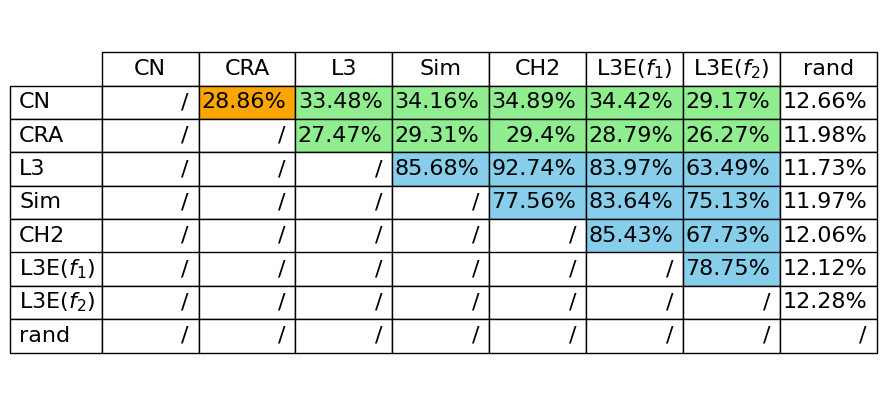

In [17]:
print("BioSNAP, 50")
tmp, tmpColor = overlaps_mats_str[50]['biosnap'], overlaps_mats_colors[50]['biosnap']
myMethods = ["CN", "CRA", "L3",  "Sim","CH2", "L3E($f_{1}$)", "L3E($f_{2}$)", "rand"]#"CH2",

fig, ax =plt.subplots(1,1, figsize=(5, 5))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tmp, rowLabels=myMethods, colLabels=myMethods, cellColours=tmpColor, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

BioSNAP, 50


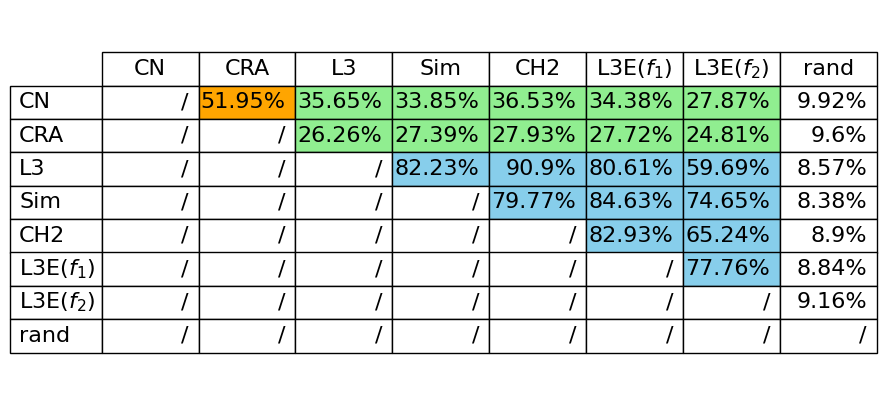

In [20]:
print("BioSNAP, 50")
tmp, tmpColor = overlaps_mats_str[60]['biosnap'], overlaps_mats_colors[50]['biosnap']
myMethods = ["CN", "CRA", "L3",  "Sim","CH2", "L3E($f_{1}$)", "L3E($f_{2}$)", "rand"]#"CH2",

fig, ax =plt.subplots(1,1, figsize=(5, 5))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tmp, rowLabels=myMethods, colLabels=myMethods, cellColours=tmpColor, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

BioSNAP, 50


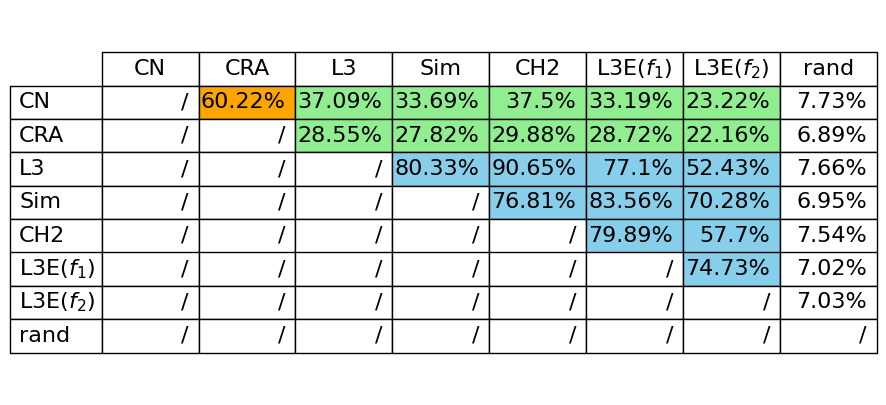

In [21]:
print("BioSNAP, 50")
tmp, tmpColor = overlaps_mats_str[70]['biosnap'], overlaps_mats_colors[50]['biosnap']
myMethods = ["CN", "CRA", "L3",  "Sim","CH2", "L3E($f_{1}$)", "L3E($f_{2}$)", "rand"]#"CH2",

fig, ax =plt.subplots(1,1, figsize=(5, 5))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tmp, rowLabels=myMethods, colLabels=myMethods, cellColours=tmpColor, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

BioSNAP, 50


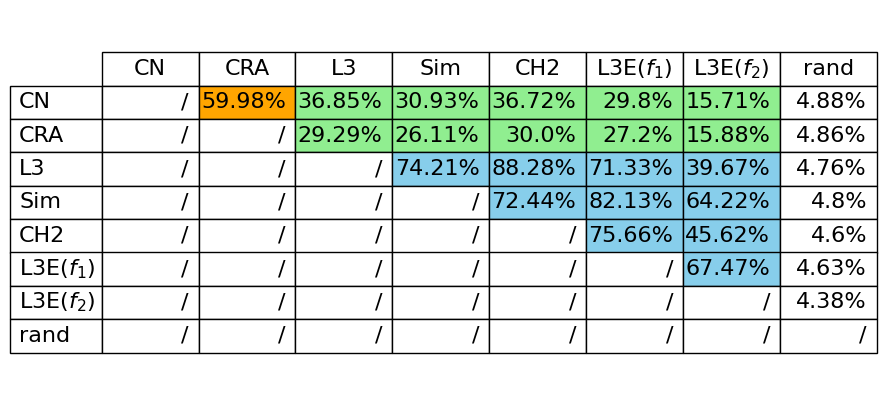

In [22]:
print("BioSNAP, 50")
tmp, tmpColor = overlaps_mats_str[80]['biosnap'], overlaps_mats_colors[50]['biosnap']
myMethods = ["CN", "CRA", "L3",  "Sim","CH2", "L3E($f_{1}$)", "L3E($f_{2}$)", "rand"]#"CH2",

fig, ax =plt.subplots(1,1, figsize=(5, 5))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tmp, rowLabels=myMethods, colLabels=myMethods, cellColours=tmpColor, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

BioSNAP, 90


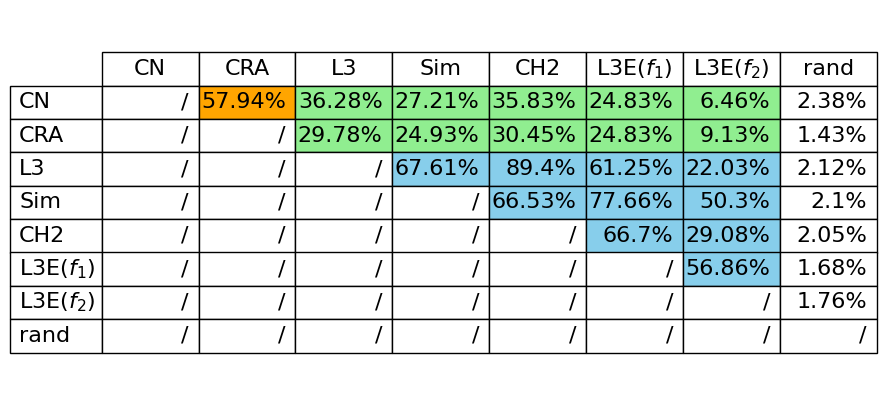

In [24]:
print("BioSNAP, 90")
tmp, tmpColor = overlaps_mats_str[90]['biosnap'], overlaps_mats_colors[50]['biosnap']
myMethods = ["CN", "CRA", "L3",  "Sim", "CH2","L3E($f_{1}$)", "L3E($f_{2}$)", "rand"]#"CH2",

fig, ax =plt.subplots(1,1, figsize=(5, 5))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tmp, rowLabels=myMethods, colLabels=myMethods, cellColours=tmpColor, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

In [45]:
# calculate overlap class-based
myMethods = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2", "rand"]
principles = ["CN", "CN", "L3", "L3", "L3", "L3", "L3", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
overlaps_mats_grouped = {}

for randSz in range(50, 100, 10):
    overlaps_mats_grouped[randSz] = {}
    for ds in ds_names:
        overlaps_mats_grouped[randSz][ds] = defaultdict(list)
        for A_i in range(len(myMethods)):
            for B_i in range(len(myMethods)):
                if B_i < A_i or A_i == B_i: continue
                methodA, methodB = myMethods[A_i], myMethods[B_i]
                overlaps_mats_grouped[randSz][ds]["{}_{}".format(principles[A_i], principles[B_i])].append(
                    np.around(len(parseTopPPIs[randSz][ds][methodA]&parseTopPPIs[randSz][ds][methodB]
                           )/len(parseTopPPIs[randSz][ds][methodA]), 4))

        overlaps_mats_grouped[randSz][ds]["CRA_L3E".format()].append(
            np.around(len(parseTopPPIs[randSz][ds]["CRA"]&parseTopPPIs[randSz][ds]["L3E1_f1"]
                   )/len(parseTopPPIs[randSz][ds]["CRA"]), 4))



# convert grouped to mean & std
overlaps_mats_mean, overlaps_mats_std = {}, {}
for randSz in range(50, 100, 10):
    overlaps_mats_mean[randSz], overlaps_mats_std[randSz] = {}, {}
    for ds in ds_names:
        overlaps_mats_mean[randSz][ds], overlaps_mats_std[randSz][ds] = {}, {}
        for pair in overlaps_mats_grouped[randSz][ds]:
            overlaps_mats_mean[randSz][ds][pair] = np.around(np.mean(overlaps_mats_grouped[randSz][ds][pair]), 2)
            overlaps_mats_std[randSz][ds][pair] = np.around(np.std(overlaps_mats_grouped[randSz][ds][pair]), 2)

print(overlaps_mats_mean)
print(overlaps_mats_std)

{50: {'biosnap': {'CN_CN': 0.29, 'CN_L3': 0.31, 'CN_rand': 0.12, 'L3_L3': 0.8, 'L3_rand': 0.12, 'CRA_L3E': 0.29}, 'ddinter_A': {'CN_CN': 0.59, 'CN_L3': 0.05, 'CN_rand': 0.06, 'L3_L3': 0.76, 'L3_rand': 0.05, 'CRA_L3E': 0.04}, 'ddinter_R': {'CN_CN': 0.57, 'CN_L3': 0.03, 'CN_rand': 0.05, 'L3_L3': 0.83, 'L3_rand': 0.03, 'CRA_L3E': 0.03}}, 60: {'biosnap': {'CN_CN': 0.52, 'CN_L3': 0.3, 'CN_rand': 0.1, 'L3_L3': 0.78, 'L3_rand': 0.09, 'CRA_L3E': 0.28}, 'ddinter_A': {'CN_CN': 0.63, 'CN_L3': 0.06, 'CN_rand': 0.04, 'L3_L3': 0.77, 'L3_rand': 0.03, 'CRA_L3E': 0.06}, 'ddinter_R': {'CN_CN': 0.6, 'CN_L3': 0.04, 'CN_rand': 0.03, 'L3_L3': 0.79, 'L3_rand': 0.02, 'CRA_L3E': 0.05}}, 70: {'biosnap': {'CN_CN': 0.6, 'CN_L3': 0.3, 'CN_rand': 0.07, 'L3_L3': 0.75, 'L3_rand': 0.07, 'CRA_L3E': 0.29}, 'ddinter_A': {'CN_CN': 0.67, 'CN_L3': 0.09, 'CN_rand': 0.03, 'L3_L3': 0.77, 'L3_rand': 0.02, 'CRA_L3E': 0.09}, 'ddinter_R': {'CN_CN': 0.57, 'CN_L3': 0.06, 'CN_rand': 0.02, 'L3_L3': 0.77, 'L3_rand': 0.02, 'CRA_L3E': 0.

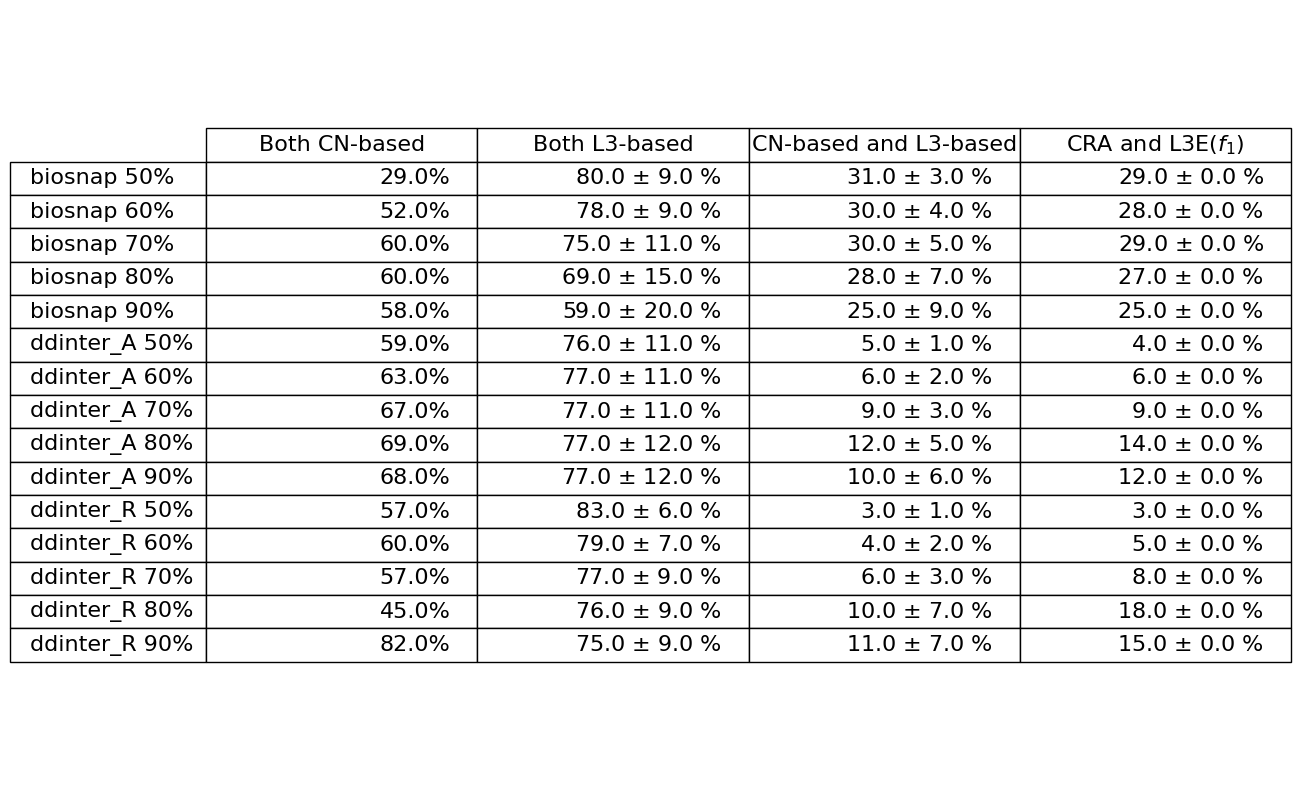

In [50]:
# overlaps_mats_mean, overlaps_mats_std
# y: dataset w sample size, x: principle pair
principlePairs = ['CN_CN', 'L3_L3', 'CN_L3', 'CRA_L3E']
principlesMap = {
    'CN_CN': 'Both CN-based',
    'L3_L3': 'Both L3-based',
    'CN_L3': 'CN-based and L3-based',
    'CRA_L3E': 'CRA and L3E($f_{1}$)'
}
dsLabels = []

overlapMeanTB_str = []
for ds in ['biosnap', 'ddinter_A', 'ddinter_R']:
    for randSz in range(50, 100, 10):
        overlapMeanTB_str.append([])
        for pair in principlePairs:
            if 'rand' in pair: continue
            if 'CN_CN' == pair:
                overlapMeanTB_str[-1].append(
                    str(np.around(overlaps_mats_mean[randSz][ds][pair]*100))+"%")
            else:
                overlapMeanTB_str[-1].append(
                    str(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2))+" $\pm$ "+str(
                        np.around(overlaps_mats_std[randSz][ds][pair]*100, 2))+" %")
        dsLabels.append("{} {}%".format(ds, randSz))

fig, ax =plt.subplots(1,1, figsize=(7, 10))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=overlapMeanTB_str, rowLabels=dsLabels
                     , colLabels=[principlesMap[i] for i in principlePairs], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(2, 2)
plt.show()

In [47]:
import_funcs = {
    'biosnap': '/content/drive/MyDrive/DDI_Dataset/BioSNAP/processed_drug_pairs_biosnap.csv',
    'ddinter_A': '/content/drive/MyDrive/DDI_Dataset/DDInter/processed_drug_pairs_DDInter_A.csv',
    'ddinter_R': '/content/drive/MyDrive/DDI_Dataset/DDInter/processed_drug_pairs_DDInter.csv'
}

truth_PPIs = {}

for name, filepath in import_funcs.items():
    df = pd.read_csv(filepath)
    # Convert values to strings explicitly before joining
    truth_PPIs[name] = set(df[['nodeA', 'nodeB']].astype(str).apply(lambda x: '\t'.join(x), axis=1))



In [48]:
# calculate overlap class-based
# true-positive only
myMethods = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2", "rand"]
principles = ["CN", "CN", "L3", "L3", "L3", "L3", "L3", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
overlaps_mats_grouped = {}

for randSz in range(50, 100, 10):
    overlaps_mats_grouped[randSz] = {}
    for ds in ds_names:
        overlaps_mats_grouped[randSz][ds] = defaultdict(list)
        for A_i in range(len(myMethods)):
            for B_i in range(len(myMethods)):
                if B_i < A_i or A_i == B_i: continue
                methodA, methodB = myMethods[A_i], myMethods[B_i]
                overlaps_mats_grouped[randSz][ds]["{}_{}".format(principles[A_i], principles[B_i])].append(
                    np.around(len(parseTopPPIs[randSz][ds][methodA]&parseTopPPIs[randSz][ds][methodB]
                           )/len(parseTopPPIs[randSz][ds][methodA]), 4))

        overlaps_mats_grouped[randSz][ds]["CRA_L3E".format()].append(
            np.around(len(parseTopPPIs[randSz][ds]["CRA"]&parseTopPPIs[randSz][ds]["L3E1_f1"]
                   )/len(parseTopPPIs[randSz][ds]["CRA"]), 4))



# convert grouped to mean & std
overlaps_mats_mean, overlaps_mats_std = {}, {}
for randSz in range(50, 100, 10):
    overlaps_mats_mean[randSz], overlaps_mats_std[randSz] = {}, {}
    for ds in ds_names:
        overlaps_mats_mean[randSz][ds], overlaps_mats_std[randSz][ds] = {}, {}
        for pair in overlaps_mats_grouped[randSz][ds]:
            overlaps_mats_mean[randSz][ds][pair] = np.around(np.mean(overlaps_mats_grouped[randSz][ds][pair]), 2)
            overlaps_mats_std[randSz][ds][pair] = np.around(np.std(overlaps_mats_grouped[randSz][ds][pair]), 2)

print(overlaps_mats_mean)
print(overlaps_mats_std)

{50: {'biosnap': {'CN_CN': 0.29, 'CN_L3': 0.31, 'CN_rand': 0.12, 'L3_L3': 0.8, 'L3_rand': 0.12, 'CRA_L3E': 0.29}, 'ddinter_A': {'CN_CN': 0.59, 'CN_L3': 0.05, 'CN_rand': 0.06, 'L3_L3': 0.76, 'L3_rand': 0.05, 'CRA_L3E': 0.04}, 'ddinter_R': {'CN_CN': 0.57, 'CN_L3': 0.03, 'CN_rand': 0.05, 'L3_L3': 0.83, 'L3_rand': 0.03, 'CRA_L3E': 0.03}}, 60: {'biosnap': {'CN_CN': 0.52, 'CN_L3': 0.3, 'CN_rand': 0.1, 'L3_L3': 0.78, 'L3_rand': 0.09, 'CRA_L3E': 0.28}, 'ddinter_A': {'CN_CN': 0.63, 'CN_L3': 0.06, 'CN_rand': 0.04, 'L3_L3': 0.77, 'L3_rand': 0.03, 'CRA_L3E': 0.06}, 'ddinter_R': {'CN_CN': 0.6, 'CN_L3': 0.04, 'CN_rand': 0.03, 'L3_L3': 0.79, 'L3_rand': 0.02, 'CRA_L3E': 0.05}}, 70: {'biosnap': {'CN_CN': 0.6, 'CN_L3': 0.3, 'CN_rand': 0.07, 'L3_L3': 0.75, 'L3_rand': 0.07, 'CRA_L3E': 0.29}, 'ddinter_A': {'CN_CN': 0.67, 'CN_L3': 0.09, 'CN_rand': 0.03, 'L3_L3': 0.77, 'L3_rand': 0.02, 'CRA_L3E': 0.09}, 'ddinter_R': {'CN_CN': 0.57, 'CN_L3': 0.06, 'CN_rand': 0.02, 'L3_L3': 0.77, 'L3_rand': 0.02, 'CRA_L3E': 0.

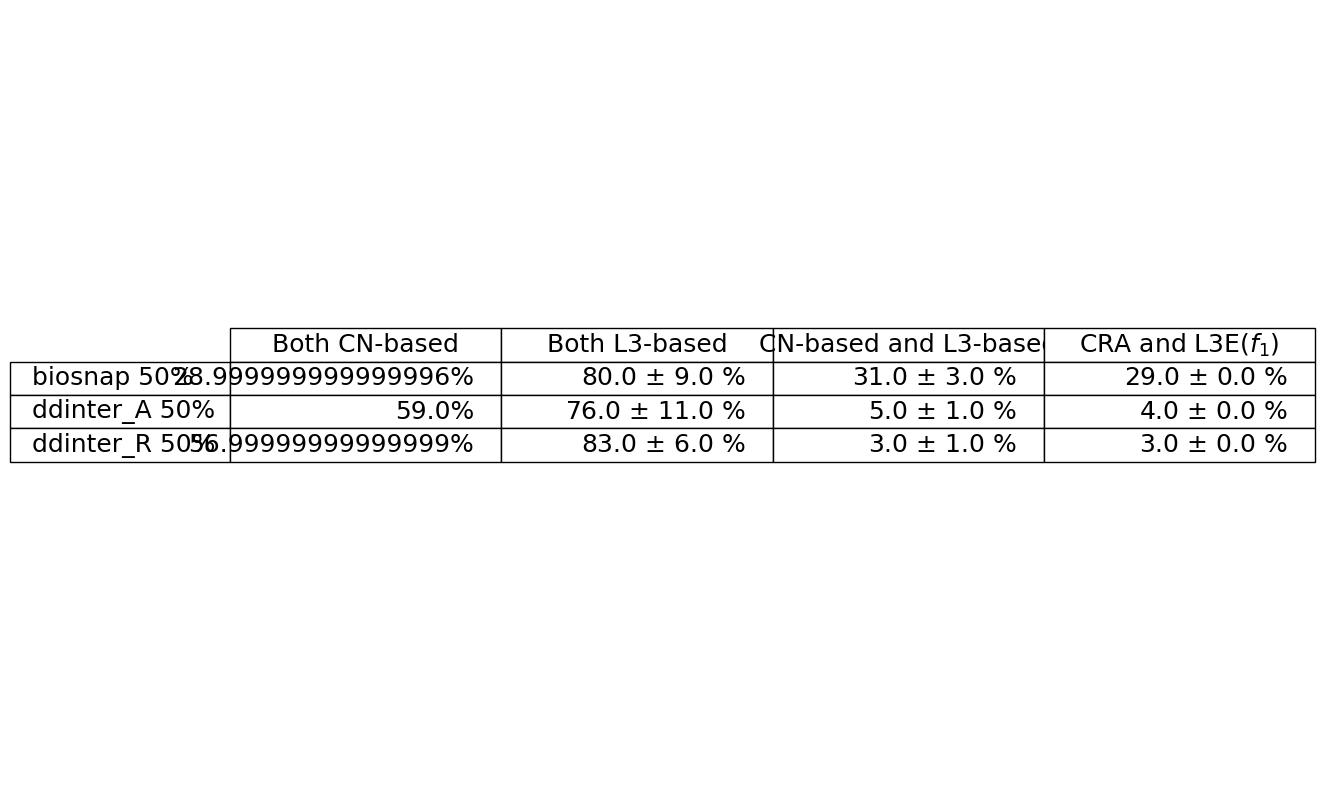

In [49]:
# overlaps_mats_mean, overlaps_mats_std
# y: dataset w sample size, x: principle pair
principlePairs = ['CN_CN', 'L3_L3', 'CN_L3', 'CRA_L3E']
principlesMap = {
    'CN_CN': 'Both CN-based',
    'L3_L3': 'Both L3-based',
    'CN_L3': 'CN-based and L3-based',
    'CRA_L3E': 'CRA and L3E($f_{1}$)'
}
dsLabels = []

overlapMeanTB_str = []
for ds in ['biosnap', 'ddinter_A', 'ddinter_R']:
    for randSz in range(50, 51, 10):
        overlapMeanTB_str.append([])
        for pair in principlePairs:
            if 'rand' in pair: continue
            if 'CN_CN' == pair:
                overlapMeanTB_str[-1].append(
                    str(overlaps_mats_mean[randSz][ds][pair]*100)+"%")
            else:
                overlapMeanTB_str[-1].append(
                    str(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2))+" $\pm$ "+str(
                        np.around(overlaps_mats_std[randSz][ds][pair]*100, 2))+" %")
        dsLabels.append("{} {}%".format(ds, randSz))

fig, ax =plt.subplots(1,1, figsize=(7, 10))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=overlapMeanTB_str, rowLabels=dsLabels
                     , colLabels=[principlesMap[i] for i in principlePairs], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)
plt.show()

In [41]:
# overlaps_mats_mean, overlaps_mats_std
# y: dataset w sample size, x: principle pair
principlePairs = ['CN_CN', 'L3_L3', 'CN_L3', 'CRA_L3E']
colors = ["blue", "blue", "red", "red"]
colorsMap = dict(zip(principlePairs, colors))

overlapMeanTB_str = []
for ds in ['biosnap', 'ddinter_A', 'ddinter_R']:
    for randSz in range(50, 51, 10):
        buildStr = "\cellcolor{gray!15} "+ds
        for pair in principlePairs:
            if 'rand' in pair: continue
            if 'CN_CN' == pair or "CRA" in pair:
                buildStr += " & \\textcolor{"+colorsMap[pair]+"}{"+(str(int(overlaps_mats_mean[randSz][ds][pair]*100))+"\\%}")
            else:
                buildStr += " & \\textcolor{"+colorsMap[pair]+"}{"+(str(int(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2)))+" $\\pm$ "+str(
                        int(np.around(overlaps_mats_std[randSz][ds][pair]*100, 2)))+" \\%}")
        print(buildStr+" \\\\ \\hline")

KeyError: 'CN_CN'

In [ ]:
# overlaps_mats_mean, overlaps_mats_std
# y: dataset w sample size, x: principle pair
principlePairs = ['CN_CN', 'L3_L3', 'CN_L3', 'CRA_L3E']
colors = ["blue", "blue", "red", "red"]
colorsMap = dict(zip(principlePairs, colors))

overlapMeanTB_str = []
for ds in ['bioGRID', 'STRING', 'MINT']:
    print("\\multicolumn{5}{|l|}{\\textbf{"+ds+" Yeast}} \\\\ \\hline")
    for randSz in range(50, 100, 10):
        buildStr = "\\cellcolor{gray!15} "+str(randSz)+"\\% sample size"
        for pair in principlePairs:
            if 'rand' in pair: continue
            if 'CN_CN' == pair or "CRA" in pair:
                buildStr += " & \\textcolor{"+colorsMap[pair]+"}{"+(str(int(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2)))+"\\%}")
            else:
                buildStr += " & \\textcolor{"+colorsMap[pair]+"}{"+(str(int(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2)))+" $\\pm$ "+str(
                        int(np.around(overlaps_mats_std[randSz][ds][pair]*100, 2)))+" \\%}")
        print(buildStr+" \\\\ \\hline")

\multicolumn{5}{|l|}{\textbf{bioGRID Yeast}} \\ \hline
\cellcolor{gray!15} 50\% sample size & \textcolor{blue}{69\%} & \textcolor{blue}{79 $\pm$ 10 \%} & \textcolor{red}{30 $\pm$ 6 \%} & \textcolor{red}{35\%} \\ \hline
\cellcolor{gray!15} 60\% sample size & \textcolor{blue}{73\%} & \textcolor{blue}{64 $\pm$ 15 \%} & \textcolor{red}{30 $\pm$ 9 \%} & \textcolor{red}{41\%} \\ \hline
\cellcolor{gray!15} 70\% sample size & \textcolor{blue}{74\%} & \textcolor{blue}{64 $\pm$ 14 \%} & \textcolor{red}{31 $\pm$ 11 \%} & \textcolor{red}{45\%} \\ \hline
\cellcolor{gray!15} 80\% sample size & \textcolor{blue}{74\%} & \textcolor{blue}{59 $\pm$ 16 \%} & \textcolor{red}{31 $\pm$ 13 \%} & \textcolor{red}{46\%} \\ \hline
\cellcolor{gray!15} 90\% sample size & \textcolor{blue}{76\%} & \textcolor{blue}{52 $\pm$ 18 \%} & \textcolor{red}{31 $\pm$ 16 \%} & \textcolor{red}{45\%} \\ \hline
\multicolumn{5}{|l|}{\textbf{STRING Yeast}} \\ \hline
\cellcolor{gray!15} 50\% sample size & \textcolor{blue}{89\%} & \tex

In [36]:
# calculate overlap class-based
myMethods = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2", "rand"]
principles = ["CN", "CN", "L3", "L3", "L3", "L3", "L3", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
overlaps_mats_grouped = {}

for randSz in range(50, 51, 10):
    overlaps_mats_grouped[randSz] = {}
    for ds in ds_names:
        overlaps_mats_grouped[randSz][ds] = defaultdict(list)
        for methodA in ["L3E1_f1"]:
            for B_i in range(len(myMethods)):
                methodB = myMethods[B_i]
                if methodA == methodB: continue
                overlaps_mats_grouped[randSz][ds]["{}_L3E(f1)".format(methodB)].append(
                    np.around(len(parseTopPPIs[randSz][ds][methodA]&parseTopPPIs[randSz][ds][methodB]
                           )/len(parseTopPPIs[randSz][ds][methodA]), 4))

# convert grouped to mean & std
overlaps_mats_mean = {}
for randSz in range(50, 51, 10):
    overlaps_mats_mean[randSz] = {}
    for ds in ds_names:
        overlaps_mats_mean[randSz][ds] = {}
        for pair in overlaps_mats_grouped[randSz][ds]:
            overlaps_mats_mean[randSz][ds][pair] = np.around(np.mean(overlaps_mats_grouped[randSz][ds][pair]), 2)

print(overlaps_mats_mean)

{50: {'biosnap': {'CN_L3E(f1)': 0.35, 'CRA_L3E(f1)': 0.17, 'L3_L3E(f1)': 0.65, 'CH2_L3E(f1)': 0.71, 'Sim_L3E(f1)': 0.76, 'L3E1_f2_L3E(f1)': 0.79, 'rand_L3E(f1)': 0.12}, 'ddinter_A': {'CN_L3E(f1)': 0.11, 'CRA_L3E(f1)': 0.1, 'L3_L3E(f1)': 0.84, 'CH2_L3E(f1)': 0.81, 'Sim_L3E(f1)': 0.57, 'L3E1_f2_L3E(f1)': 0.87, 'rand_L3E(f1)': 0.05}, 'ddinter_R': {'CN_L3E(f1)': 0.07, 'CRA_L3E(f1)': 0.08, 'L3_L3E(f1)': 0.85, 'CH2_L3E(f1)': 0.88, 'Sim_L3E(f1)': 0.73, 'L3E1_f2_L3E(f1)': 0.89, 'rand_L3E(f1)': 0.03}}}


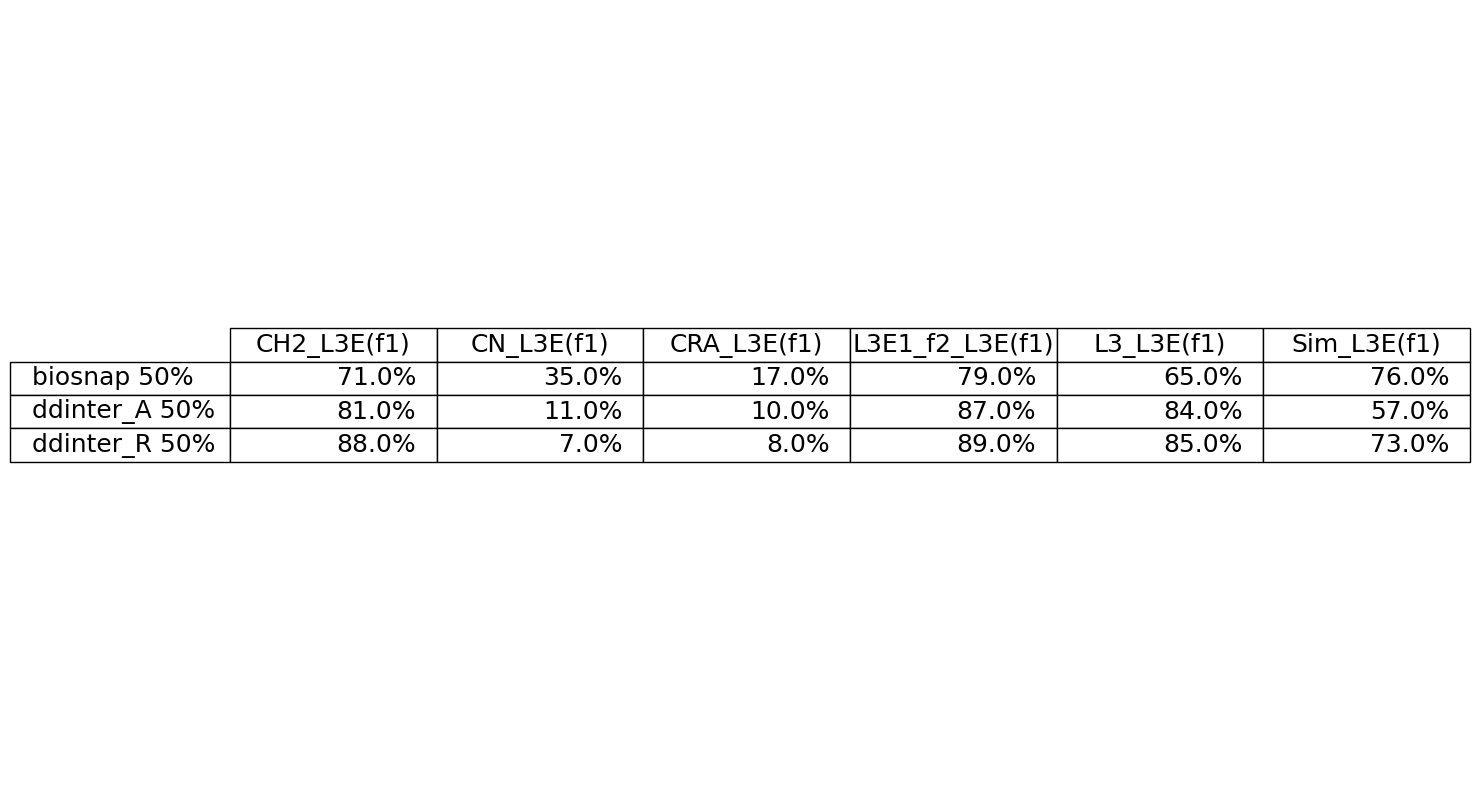

In [38]:
# overlaps_mats_mean, overlaps_mats_std
# y: dataset w sample size, x: principle pair
principlePairs = sorted([i for i in list(overlaps_mats_mean[50]['biosnap'].keys()) if 'rand' not in i])
dsLabels = []

overlapMeanTB_str = []
for ds in ['biosnap', 'ddinter_A', 'ddinter_R']:
    for randSz in range(50, 51, 10):
        overlapMeanTB_str.append([])
        for pair in sorted(list(overlaps_mats_mean[randSz][ds].keys())):
            if 'rand' in pair: continue
            overlapMeanTB_str[-1].append(
                str(np.around(overlaps_mats_mean[randSz][ds][pair]*100, 2))+"%")
        dsLabels.append("{} {}%".format(ds, randSz))

fig, ax =plt.subplots(1,1, figsize=(8, 10))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=overlapMeanTB_str, rowLabels=dsLabels
                     , colLabels=principlePairs, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)
plt.show()

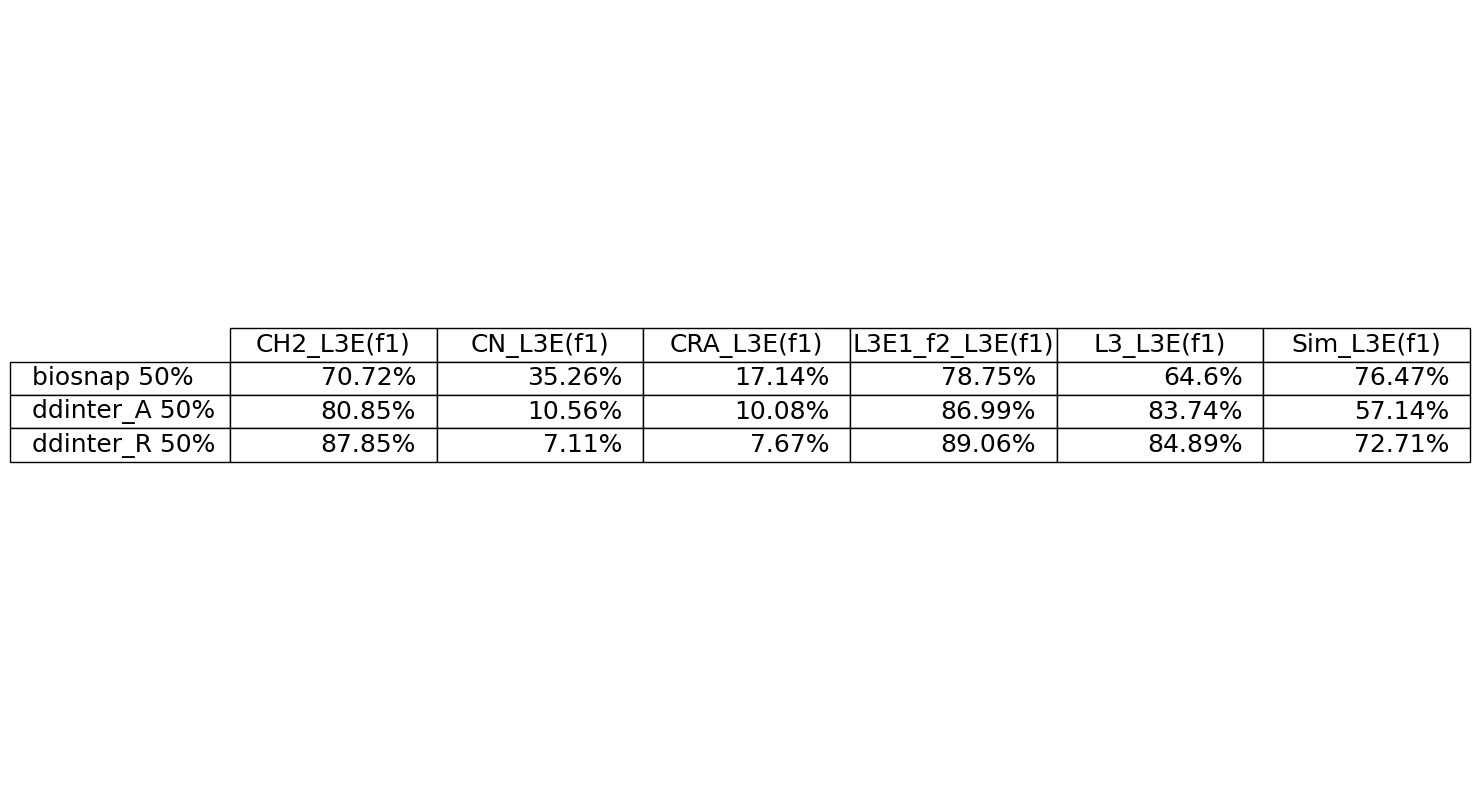

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the file paths for importing data
import_funcs = {
    'biosnap': '/content/drive/MyDrive/DDI_Dataset/BioSNAP/processed_drug_pairs_biosnap.csv',
    'ddinter_A': '/content/drive/MyDrive/DDI_Dataset/DDInter/processed_drug_pairs_DDInter_A.csv',
    'ddinter_R': '/content/drive/MyDrive/DDI_Dataset/DDInter/processed_drug_pairs_DDInter.csv'
}

# Calculate overlaps between different pairs of methods
myMethods = ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2", "rand"]
principles = ["CN", "CN", "L3", "L3", "L3", "L3", "L3", "rand"]
ds_names = ['biosnap', 'ddinter_A', 'ddinter_R']
overlaps_mats_grouped = {}

for randSz in range(50, 51, 10):
    overlaps_mats_grouped[randSz] = {}
    for ds in ds_names:
        overlaps_mats_grouped[randSz][ds] = defaultdict(list)
        for methodA in ["L3E1_f1"]:
            for B_i in range(len(myMethods)):
                methodB = myMethods[B_i]
                if methodA == methodB:
                    continue
                overlap = len(parseTopPPIs[randSz][ds][methodA] & parseTopPPIs[randSz][ds][methodB]) / len(parseTopPPIs[randSz][ds][methodA])
                overlaps_mats_grouped[randSz][ds]["{}_L3E(f1)".format(methodB)].append(np.around(overlap, 4))

# Convert grouped overlaps to mean values
overlaps_mats_mean = {}
for randSz in range(50, 51, 10):
    overlaps_mats_mean[randSz] = {}
    for ds in ds_names:
        overlaps_mats_mean[randSz][ds] = {}
        for pair in overlaps_mats_grouped[randSz][ds]:
            overlaps_mats_mean[randSz][ds][pair] = np.mean(overlaps_mats_grouped[randSz][ds][pair])

# Generate table data for visualization
principlePairs = sorted([i for i in list(overlaps_mats_mean[50]['biosnap'].keys()) if 'rand' not in i])
dsLabels = []

overlapMeanTB_str = []
for ds in ['biosnap', 'ddinter_A', 'ddinter_R']:
    for randSz in range(50, 51, 10):
        overlapMeanTB_str.append([])
        for pair in sorted(list(overlaps_mats_mean[randSz][ds].keys())):
            if 'rand' in pair:
                continue
            overlapMeanTB_str[-1].append(str(np.around(overlaps_mats_mean[randSz][ds][pair] * 100, 2)) + "%")
        dsLabels.append("{} {}%".format(ds, randSz))

# Plot the table
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=overlapMeanTB_str, rowLabels=dsLabels, colLabels=principlePairs, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)
plt.show()
